In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [4]:
words = open('names.txt', 'r').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [16]:
# build vocabulary of characters 
chars = sorted(list(set(''.join(word for word in words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0 
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [24]:
# build the dataset 

block_size = 3 # how many characters to take to predict the next character 
X, Y = [], [] 

for word in words[:5]:
    print(word)
    context = [0] * block_size 
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix) 
        print(''.join(itos[i] for i in context), '------>', itos[ix])    
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ------> e
..e ------> m
.em ------> m
emm ------> a
mma ------> .
olivia
... ------> o
..o ------> l
.ol ------> i
oli ------> v
liv ------> i
ivi ------> a
via ------> .
ava
... ------> a
..a ------> v
.av ------> a
ava ------> .
isabella
... ------> i
..i ------> s
.is ------> a
isa ------> b
sab ------> e
abe ------> l
bel ------> l
ell ------> a
lla ------> .
sophia
... ------> s
..s ------> o
.so ------> p
sop ------> h
oph ------> i
phi ------> a
hia ------> .


In [26]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [31]:
C = torch.randn((27, 2)) # embedding vectors 

In [35]:
# 1. One way of getting embedding vector is to pluck out with index 
C[5]

tensor([ 0.2433, -0.2403])

In [37]:
# 2. The other way is using one hot vector and do matrix multiplication --> same result, but inefficient.  
xenc = F.one_hot(torch.tensor(5), num_classes = 27).float()
xenc @ C 

tensor([ 0.2433, -0.2403])

In [39]:
C[X].shape # indexing can be multi-dimensional --> num of examples x num of chars x embed dim 

torch.Size([32, 3, 2])

In [45]:
C[X][13,2] == C[X[13,2]]

tensor([True, True])

In [69]:
emb = C[X] 
print(emb.shape)
print((emb.view(-1, 6) == torch.concat(torch.unbind(emb, 1), 1)).all()) # (32 x 3 x 2) --> unbind(1) --> (32 x 2), (32 x 2), (32 x 2) --> concat --> (32 x 6) 
# view() is more efficient than unbind+concat. Does not have to create/copy/move data/memory.  
print(emb.view(-1, 6).shape)

torch.Size([32, 3, 2])
tensor(True)
torch.Size([32, 6])


In [70]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [74]:
(emb.view(-1,6) @ W1 + b1).shape
# 32 x 100 + b1? 
# 32, 100 
#  1, 100 <---- broadcasting rule. starts from the right most. The empty dimension will be replaced with 1, and the value will be copied on this dim. (1-->32)

torch.Size([32, 100])

In [73]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [75]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [79]:
logits = h @ W2 + b2 
print(logits.shape)
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True) 
print(probs.sum(1))

torch.Size([32, 27])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [82]:
probs[torch.arange(32), Y] # probs assigned by the network to the target characters 

tensor([1.9658e-03, 3.0392e-04, 4.2395e-06, 3.5193e-05, 5.7438e-11, 1.0018e-03,
        4.8308e-16, 3.8880e-12, 3.6279e-02, 1.1094e-14, 9.2756e-04, 5.4691e-10,
        2.7275e-04, 2.0746e-03, 1.3650e-03, 9.2134e-06, 2.8197e-12, 5.2726e-07,
        1.8524e-10, 4.4002e-16, 1.8582e-02, 1.9146e-11, 1.6499e-13, 2.0986e-04,
        6.0006e-11, 2.0750e-09, 2.0190e-06, 6.1167e-12, 7.7565e-06, 2.6598e-08,
        1.3555e-02, 3.7201e-11])

In [87]:
loss = - probs[torch.arange(32), Y].log().mean() # mean negative log likelihood loss --> cross entropy
print(loss)
loss = F.cross_entropy(logits, Y) # logtits as input. 
print(loss)

# F.cross_entropy is more efficient and numerically stable. 
# 1) why more efficient? torch internally uses fused kernels for softmax+cross_entropy loss calculation. No shit tons of read/write. 
# 2) why more numerically stable? torch internally deals with numerical overflow. e^x --> e^x * e^(-x.max()). just offset the exponent. 

tensor(16.5841)
tensor(16.5841)


## Let's find a proper learning rate!  

In [131]:
# create the dataset 
block_size = 3 # how many characters to take to predict the next character 
X, Y = [], [] 

for word in words:
    # print(word)
    context = [0] * block_size 
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix) 
        # print(''.join(itos[i] for i in context), '------>', itos[ix])    
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [132]:
# parameters setting 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [133]:
print(f"number of parameters = {sum(p.nelement() for p in parameters)}")

number of parameters = 3481


In [134]:
for p in parameters:
    p.requires_grad = True 

In [135]:
# learning rate candidates 
lre = torch.linspace(-3, 0, 1000) # exponent
lrs = 10 ** lre # 0.001 ~ 1.0 , 1000 candidates 

In [136]:
lri = [] 
lossi = [] 

for k in range(1000):
    # mini-batch 
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass 
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # logtits as input. 
    # if k%100 == 0:
    #     print(f'loss = {loss.item()}')
    # backward pass 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    lr = lrs[k] 
    for p in parameters:
        p.data -= lr * p.grad 
    lri.append(lr)
    lossi.append(loss.item())

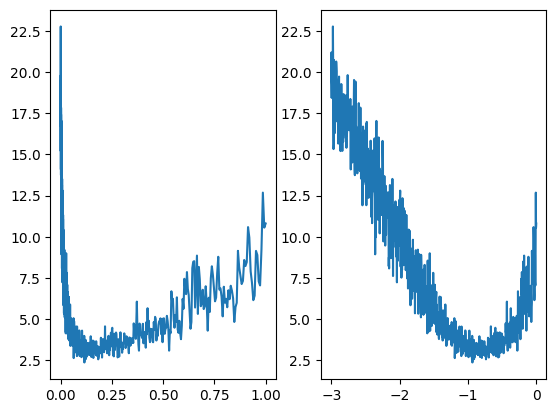

In [141]:
plt.subplot(1, 2, 1)
plt.plot(lri, lossi)
plt.subplot(1, 2, 2)
plt.plot(lre, lossi)

In [124]:
# full-batch training loss
emb = C[X] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y) 
loss

tensor(2.6878, grad_fn=<NllLossBackward0>)

## Split the dataset and train! 

In [158]:
# parameters setting 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"number of parameters = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True 

number of parameters = 3481


In [145]:
# create the dataset 
def build_dataset(words):
    block_size = 3 # how many characters to take to predict the next character 
    X, Y = [], [] 
    for word in words:
        # print(word)
        context = [0] * block_size 
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            # print(''.join(itos[i] for i in context), '------>', itos[ix])    
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8) 
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [159]:
stepi = [] 
loglossi = [] 

In [166]:
for k in range(10000):
    # mini-batch 
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass 
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # logtits as input. 

    # backward pass 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    for p in parameters:
        p.data -= 0.01 * p.grad 
    stepi.append(k)
    loglossi.append(loss.log().item())

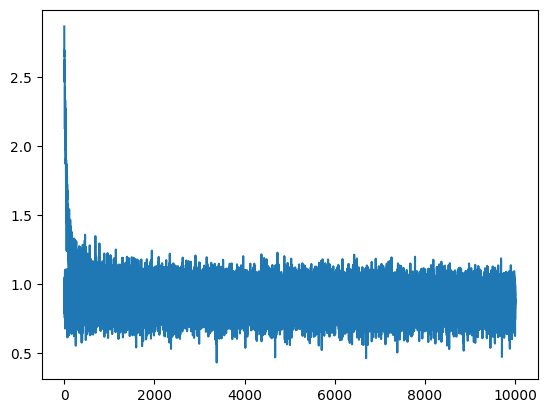

In [167]:
plt.plot(stepi, loglossi)